In [1]:
%reset -f
%clear

In [2]:
### Importing Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import quantecon as qe
import collections
import math
from matplotlib.pyplot import cm
import time

### Steady-State Distributions

----


In [3]:
#####################################################################################
# Goal: 
#    This part of codes aims to solve the steady-state produtivity distribution
#    and the value functions The numerial results provide the illustration of 
#    models/ mechanism
#
# Structure:
#    Part I : Set the values of parameters
#    Part II: Given the value of lambda, calculate the steady-state distribution
#              The method is the discretization. 
#    Part III : Given the steady-state distribution, and the guess of wage and lambda, 
#              calculate the value fucntions.
#    Part IV  : Use the entry conditions to pin down the value of wage and lambda
#    Part V : Calculate the number of markets, N
#
#####################################################################################


def utility(c,l, beta, a):
    
    '''
        Given the consumption c and labor supply l, give out the temporal utility
        Inputs: 
            beta: discount rate, parameter, data-type: scaler
            a: elasticity of labor supply, parameter, data-type: scaler
            c: consumption, variable, data-type: n * 1 vector
            l: labor, variable, data-type: n * 1 vector
        Outputs:
            utility: data-type: n * 1 vector
    '''

    return beta*math.log(c) - a * l

def prof_1(z, w, theta, a):
    
    '''
        Given the productivity, z, and the wage, w, give out the profit
        Inputs:
            theta: elasticity of substitution between goods, parameter, data-type: scaler
            z: productivity, variable, data-type: scaler
            w: wage, variable, data-type: scaler
        Outputs:
            profit: data-type: scaler
    '''

    Y = w/a
    profit = np.ones(len(z))
    for i in range(len(z)):
        profit[i] = Y * (theta/(theta-1)*w/z[i])**(1-theta)/theta
    
    return profit

def prof_2(z, z_, w, theta, a):
    
    '''
        Given the own productivity, z, compititor's productivity z_, and the wage, w, 
        give out the profit
        Inputs:
            theta: elasticity of substitution between goods, parameter, data-type: scaler
            z,z_: productivity, variable, data-type: scaler
            w: wage, variable, data-type: scaler
        Outputs:
            profit: data-type: scaler
    '''
    
    profit = np.zeros([len(z),len(z_)])
    for i in range(len(z)):
        for j in range(len(z_)):
            # pin down the market share, s
            s = ((1-theta)*z_[j] + theta * z[i])/(z[i] + z_[j])    
            
            # calculate the profit:
            Y = w/a
            profit[i,j] = Y * s**2/theta * (theta/(theta-s)*w/z[i])**(1-theta)
    
    return profit


###################### Part I: Paramters, values ################################### 

# Parameters
beta = 0.95
a = 0.9
theta = 1.3
delta = 0.05

# productivity grid
rho = 0.9
num_state = 50

# Assume H(z) and h(z) is CDF and PDF of uniform distribution
h = np.ones(num_state)*1/num_state
h = np.matrix(h)

# generate the productivity grid
MC = qe.markov.approximation.tauchen(rho, sigma_u=1, b = 0, m = 4, n = num_state)
z_grid = np.exp(MC.state_values)


################## Part II: Steady-State Distribution ##############################

# Calculate the Steady-state productivity distribution function of monopoly 
# markets, G_M(z)
def GM_dist(P, h, lambdax, num_state):
    
    '''
        Given the value lambdax, gives out the steady-state productivity distribution 
        of monopoly markets GM, and the corresponding GDF gM
        
        Inputs:
            P: Transition matrix of Markov chain
            h: PDF of entrants' produtivity distribution
            lambdax: proportion of duopoly markets
        Outputs:
            GM, gM: CDF and PDF of productivity distribution
    
    '''
    
    '''
        The Motion of Distribtuion Function G_M(z) follows:
            
            g_M(z') = delta/(1-lambda)h(z') 
                            + [1-delta-lambda*delta/(1-lambda)] Gamma(z',z)g_M(z)
        
            g_M(z): the PDF of productivity distribution in Monopoly markets
            h(z): the PDF of productivity distribution of Entrants
            Gamma(z',z): transition matrix of productivity Markov process
    
        In equilibrium, g_M(z') = g_M(z), 
        so the solution is:
    
            g_M(z) = (delta/(1-lambda)) * 
                    {I - [1-delta-lambda*delta/(1-lambda)] Gamma(z',z)}^{-1} h(z)
                
            I: identity matrix, dimension is the number of productitity states
        
    '''

    Gamma = np.mat(P)

    ## Calculate the steady-state CDF G_M
    eye = np.identity(num_state)

    B = eye - (1-delta-lambdax*delta/(1-lambdax))*Gamma.T
    gM = (delta)/(1-lambdax)*np.linalg.inv(B).dot(h.T)

    GM = np.cumsum(gM).T
    
    return gM, GM


# Calculate the Steady-state joint productivity distribution function of 
# duopoly markets, G_D(z)
def GD_dist(P, g, h, lambdax, num_state):
    
    '''
        Given the value lambdax, gives out the steady-state marginal productivity 
        distribution of duopoly markets GD, and the corresponding GDF gD
        
        Inputs:
            P: Tranasition matrix of Markov chain
            h: PDF of entrants' produtivity distribution
            lambdax: proportion of duopoly markets
            g: steadt-state productivity distribution of monopoly markets, PDF
        Outputs:
            gJ, GD, gD: joint PDF; CDF and PDF of marginal productivity distribution
    
    '''
    
    '''
        The Motion of Distribtuion Function G_D(z) follows:
            
           gD(z')*gD(z_')^T = (1-delta) [(Gamma^T * gD(z) )*(Gamma^T * gD(z_))^T] + 
                     (delta/2) [(Gamma^T * gM(z)) * h(z_')^T] +
                     (delta/2) [h(z') * (Gamma^T * gM(z_))^T]
        
            gM(z): the PDF of productivity distribution in Monopoly markets
            h(z): the PDF of productivity distribution of Entrants
            Gamma: transition matrix of productivity Markov process
            gD(z): marginal distribution of productivity, PDF
    
        In equilibrium, gD(z') = gD(z), 
        so the solution is:
    
            vec(gJ) = [I - (1-delta)*(Gamma^T # Gamma^T )^T]^(-1) *
                      (delta/2)* [(h # Gamma^T) + (Gamma^T # h)] vec(gM)..........(1)
                
            I: identity matrix, dimension is square of the number of productitity states
            #: Kronecker product
            vec: vectorization of a matrix
    '''
    
    start = time.time()
    
    # generate the necessary PDFs
    Gamma = np.mat(P)
    
    # construct the first line of Equation (1)
    n = int(num_state*num_state)
    L = np.identity(n) - (1-delta) * np.kron(Gamma.T, Gamma.T)
    
    # construct the second line of Equation (1)
    R1 = np.dot(np.kron(h.T, Gamma.T), g) 
    R2 = np.dot(np.kron(Gamma.T, h.T), g)
    R = (R1+R2).T
    
    # calculate the vec(gJ) and reshape it into the matrix form
    gJ = delta/2 * np.linalg.inv(L).dot(R)
    gJ = gJ.reshape((num_state, num_state), order = 'F' )
    
    # Calculate the Marginal PDF, CDF
    gD = np.sum(gJ, axis = 1)
    GD = np.cumsum(gD).T
    
    end = time.time()
    print('time spent:', end - start)

    return gJ, gD, GD


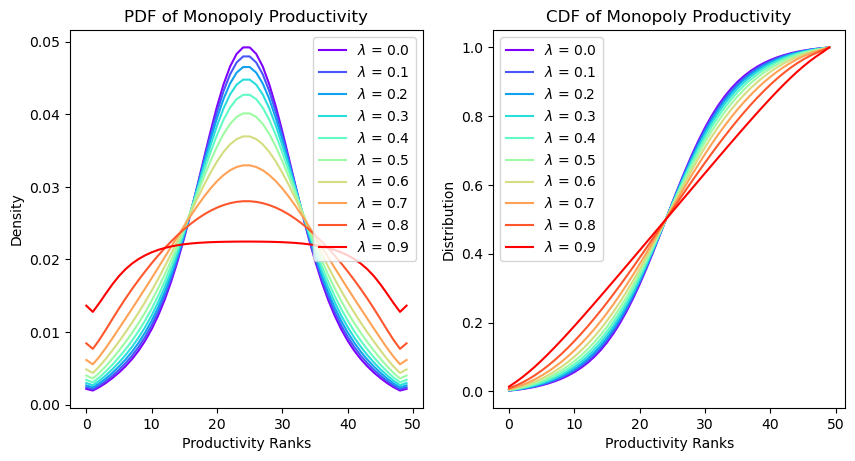

In [48]:
Lambdax = np.linspace(0,0.9,10)
gM_store = np.zeros([num_state,10])
GM_store = np.zeros([num_state,10])

for i in range(10):
    gM, GM = GM_dist(MC.P, h, Lambdax[i],num_state)
    gM_store[:,i] = np.asarray(gM)[:,0]
    GM_store[:,i] = np.asarray(GM)[:,0]

state = np.linspace(0,num_state-1, num_state)

def plot_result(text):
    color = cm.rainbow(np.linspace(0, 1, 10))
    
    fig = plt.figure(figsize = [10,5], dpi = 100)
    
    ax1 = plt.subplot(1,2,1)    
    plt.xlabel('Productivity Ranks')
    plt.ylabel('Density')
    plt.title('PDF of Monopoly Productivity')
    
    ax2 = plt.subplot(1,2,2)   
    plt.xlabel('Productivity Ranks')
    plt.ylabel('Distribution')
    plt.title('CDF of Monopoly Productivity')

    
    for i in range(10):
        ax1.plot(state, gM_store[:,i], color = color[i], label = text[i])
        ax1.legend()
        ax2.plot(state, GM_store[:,i], color = color[i], label = text[i])
        ax2.legend()
    plt.show()
    
text = ['$\lambda$ = '+ str(round(x,2)) for x in Lambdax[range(10)]]
plot_result(text)

time spent: 1.0553042888641357
time spent: 1.1822431087493896
time spent: 0.8746531009674072
time spent: 0.8850762844085693
time spent: 0.9056165218353271
time spent: 0.9094150066375732
time spent: 1.001894235610962
time spent: 1.3898682594299316
time spent: 0.8499879837036133
time spent: 1.0988874435424805


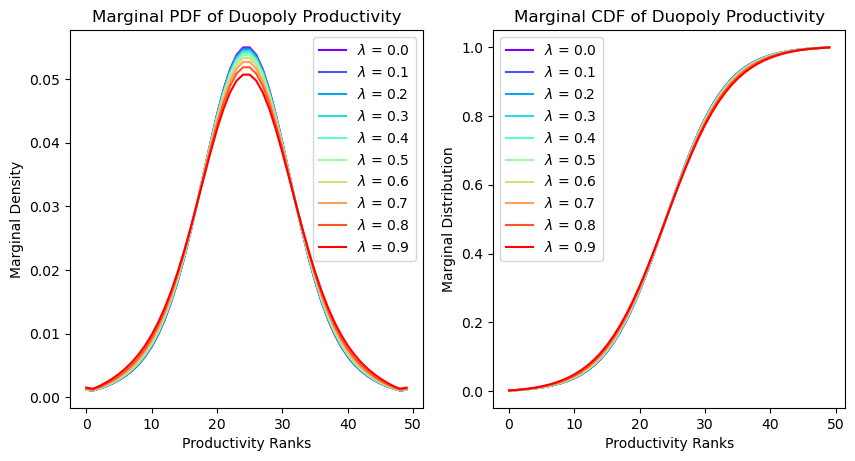

In [49]:
gJ_store = np.zeros([num_state, num_state, 10])
gD_store = np.zeros([num_state,10])
GD_store = np.zeros([num_state,10])

for i in range(10):
    gJ, gD, GD = GD_dist(MC.P, gM_store[:,i], h, Lambdax[i],50)
    gJ_store[:,:,i] = np.asarray(gJ)
    gD_store[:,i] = np.asarray(gD)[:,0]
    GD_store[:,i] = np.asarray(GD)[:,0]

state = np.linspace(0,num_state-1, num_state)

def plot_result(text):
    color = cm.rainbow(np.linspace(0, 1, 10))
    
    fig = plt.figure(figsize = [10,5], dpi = 100)
    
    ax1 = plt.subplot(1,2,1)    
    plt.xlabel('Productivity Ranks')
    plt.ylabel('Marginal Density')
    plt.title('Marginal PDF of Duopoly Productivity')
    
    ax2 = plt.subplot(1,2,2)   
    plt.xlabel('Productivity Ranks')
    plt.ylabel('Marginal Distribution')
    plt.title('Marginal CDF of Duopoly Productivity')

    
    for i in range(10):
        ax1.plot(state, gD_store[:,i], color = color[i], label = text[i])
        ax1.legend()
        ax2.plot(state, GD_store[:,i], color = color[i], label = text[i])
        ax2.legend()
    plt.show()
    
text = ['$\lambda$ = '+ str(round(x,2)) for x in Lambdax[range(10)]]
plot_result(text)

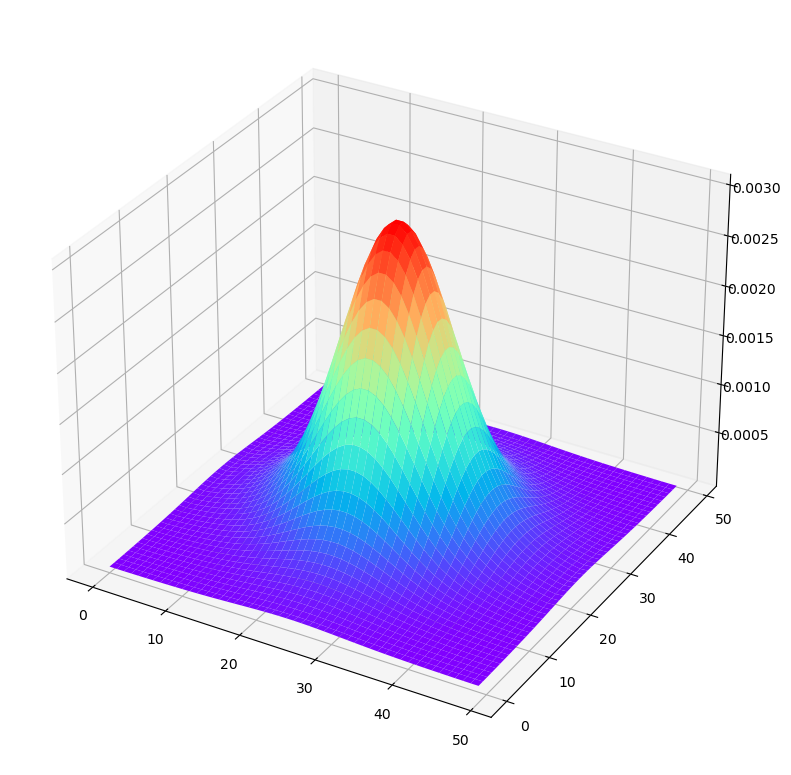

In [6]:
size = gJ_store[:,:,2].shape
X = np.arange(0, size[0], 1)
Y = np.arange(0, size[1], 1)
X, Y = np.meshgrid(X,Y)

fig = plt.figure(figsize = [10,10], dpi = 100)
ax = plt.gca(projection = '3d')
ax.plot_surface(X, Y, gJ_store[:,:,2],cmap='rainbow')
plt.show()

### Value Function Iteration

----

In [4]:
###################### Part III: Value Functions ################################### 
# Define the RHS of Bellman Equations
def Mixed_V2(V2M, V2D, V20, z_grid):
    
    '''
        Goal: the RHS of value functional equations have a weighted avergage
                values of V2. This function aims to combine different parts 
                of V2M, V2D, and V20 to prepare the weighted V2
                The base of mixture is the value of z
    '''
    
    Mixed_V2 = np.mat(np.zeros([num_state, num_state]))
    
    for i in range(len(z_grid)):
        upper = (theta)/(theta-1) * z_grid[i]
        lower = (theta-1)/theta * z_grid[i]
        if upper > z_grid[-1] and lower > z_grid[-1]:
            Mixed_V2[i] = V2M[i]
        elif upper > z_grid[-1] and z_grid[0] < lower < z_grid[-1]:
            a = int(np.where(z_grid < lower)[0][-1])
            Mixed_V2[i,0:a] = V2M[i,0:a]
            Mixed_V2[i,a:] = V2D[i,a:]
        elif upper > z_grid[-1] and lower < z_grid[0]:
            Mixed_V2[i] = V2D[i]
        elif upper < z_grid[0]:
            Mixed_V2[i] = V20[i]
        elif upper < z_grid[-1] and lower < z_grid[0]:
            b = int(np.where(z_grid < upper)[0][-1])
            Mixed_V2[i,0:b] = V2D[i,0:b]
            Mixed_V2[i,b:] = V20[i,b:]
        else:
            a = int(np.where(z_grid < lower)[0][-1])
            b = int(np.where(z_grid < upper)[0][-1])
            Mixed_V2[i,0:a] = V2M[i,0:a]
            Mixed_V2[i,a:b] = V2D[i,a:b]
            Mixed_V2[i,b:] = V20[i,b:]
    
    return Mixed_V2
      
    

In [5]:
# Value function iteration given values of w and lambda
def VF(w,lambdax):
    V1_pri = V1 = np.mat(np.zeros([num_state])).T
    V2M_pri = V2M = np.mat(np.zeros([num_state, num_state]))
    V2D_pri = V2D = np.mat(np.zeros([num_state, num_state]))
    V20_pri = V20 = np.mat(np.zeros([num_state, num_state]))
    itera = 0
    
    tor = 1
    while tor > 1e-6:
        start = time.time()
        V2M_pri = np.repeat(prof_1(z_grid, w, theta, a),num_state).reshape(num_state,num_state) + beta * (1-delta) * np.dot(MC.P,np.dot(MC.P, Mixed_V2(V2M, V2D, V20, z_grid).T))
        V2D_pri = prof_2(z_grid, z_grid, w, theta, a) + beta * (1-delta) * np.dot(MC.P,np.dot(MC.P, Mixed_V2(V2M, V2D, V20, z_grid).T))
        V20_pri = beta * (1-delta) * np.dot(MC.P,np.dot(MC.P, Mixed_V2(V2M, V2D, V20, z_grid).T))
        V1_pri = np.mat(prof_1(z_grid, w, theta, a)).T + \
                                            beta * (1-delta-lambdax*delta/(1-lambdax)) * np.dot(MC.P,V1) + \
                                            beta * lambdax*delta/(1-lambdax) * np.dot(MC.P,np.dot(h, Mixed_V2(V2M, V2D, V20, z_grid).T).T)
        
        tor1 = np.linalg.norm(V1_pri - V1)
        tor2 = np.linalg.norm(V2M_pri - V2M)
        tor3 = np.linalg.norm(V2D_pri - V2D)
        tor4 = np.linalg.norm(V20_pri - V20)
        tor = np.max((tor1, tor2, tor3, tor4))
        
        V1 = V1_pri
        V2M = V2M_pri
        V2D = V2D_pri
        V20 = V20_pri
            
        end = time.time()
        itera = itera + 1
        
#             print(itera, tor, start - end)
    print(itera, tor, end-start)
    return [V1, V2M, V2D, V20]


In [22]:
V1, V2M, V2D, V20 = VF(w=0.7, lambdax = 0.5)

1499 0.0 32.37616491317749


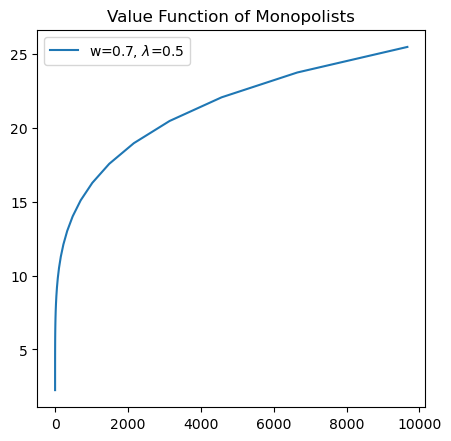

In [12]:
fig = plt.figure(figsize = [5,5], dpi = 100)
ax = plt.subplot(1,1,1)
ax.plot(z_grid, V1, label = 'w=0.7, $\lambda$=0.5')
plt.legend()
plt.title('Value Function of Monopolists')
plt.show()

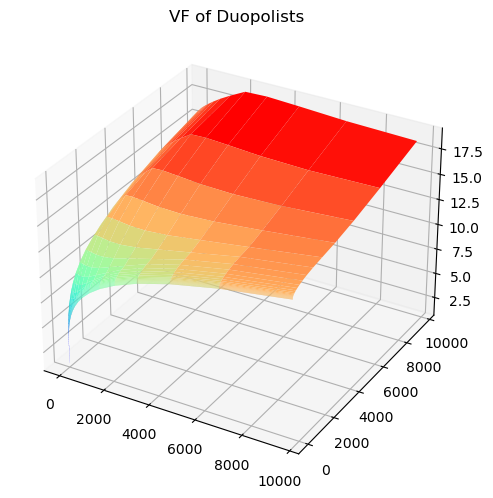

In [13]:
V2Mixed = Mixed_V2(V2M, V2D, V20, z_grid)

fig = plt.figure(figsize = [6,6], dpi = 100)
x_grid, y_grid = np.meshgrid(z_grid, z_grid)

ax1 = plt.subplot(1,1,1, projection = '3d')
ax1.plot_surface(x_grid, y_grid, V2Mixed, label = 'w=0.7, $\lambda$=0.5', cmap = 'rainbow')
plt.title('VF of Duopolists')
plt.show()

### Searching w-$\lambda$ space to meet Entry Conditions

----


In [6]:
###################### Part IV: Equilibrium values of w and lambda ################################### 
## set the value of entry consts CM, CD
CM = 10
CD = 8

'''
     larger w ---> larger V1, V2M, V2D, no effects on V20
     larger lambda ---> smaller V1, no effects on V2M, V2D, V20
     larger lambda ---> GM: fatter tails
              
'''

'''
    The next process and graph show the nearly-upper and nearly-lower bounds of 
    expected values of monopolists and duopolists given wage.
'''

## calculate the boundary values of EV1 and EV2
w1 = np.arange(0.01,2,0.1)
Ave_V1 = np.zeros([len(w1),2])
Ave_V2 = np.zeros([len(w1),2])

gM_up, GM_up = GM_dist(MC.P, h, 0.95 ,num_state)
gJ_up, gD_up, GD_up = GD_dist(MC.P, np.asarray(gM_up)[:,0], h, 0.95, num_state)

gM_lo, GM_lo = GM_dist(MC.P, h, 0.01 ,num_state)

start0 = time.time()
for i in range(len(w1)):
    V1_up, V2M_up, V2D_up, V20_up = VF(w1[i], 0.95)
    V1_lo, V2M_lo, V2D_lo, V20_lo = VF(w1[i], 0.01)
    Ave_V1[i,0] = np.dot(h,V1_up)
    Ave_V1[i,1] = np.dot(h,V1_lo)
    Ave_V2[i,1] = np.dot(h ,np.dot(gM_lo.T, Mixed_V2(V2M_lo, V2D_lo, V20_lo, z_grid).T).T)
    Ave_V2[i,0] = np.dot(h ,np.dot(gM_up.T, Mixed_V2(V2M_up, V2D_up, V20_up, z_grid).T).T)
end0 = time.time()
end0 - start0



time spent: 0.8797943592071533
135 9.74284871252484e-07 0.013393163681030273
135 9.74284871252484e-07 0.009523630142211914
152 9.125641808239193e-07 0.010051488876342773
152 9.125641808239193e-07 0.04115605354309082
156 9.519867146923482e-07 0.03730130195617676
156 9.519867146923482e-07 0.031453847885131836
159 9.191199620573037e-07 0.010087966918945312
159 9.191199620573037e-07 0.011966705322265625
161 9.104626500700071e-07 0.011325597763061523
161 9.104626500700071e-07 0.009839534759521484
162 9.573258098338847e-07 0.012145757675170898
162 9.573258098338847e-07 0.03577542304992676
163 9.793518323419975e-07 0.026879310607910156
163 9.793518323419975e-07 0.016795873641967773
164 9.829601450039945e-07 0.018307924270629883
164 9.829601450039945e-07 0.02517414093017578
165 9.72840830755224e-07 0.015326261520385742
165 9.72840830755224e-07 0.039969444274902344
166 9.525295615597864e-07 0.0065653324127197266
166 9.525295615597864e-07 0.01213383674621582
167 9.247442933935165e-07 0.018420696

141.58965420722961

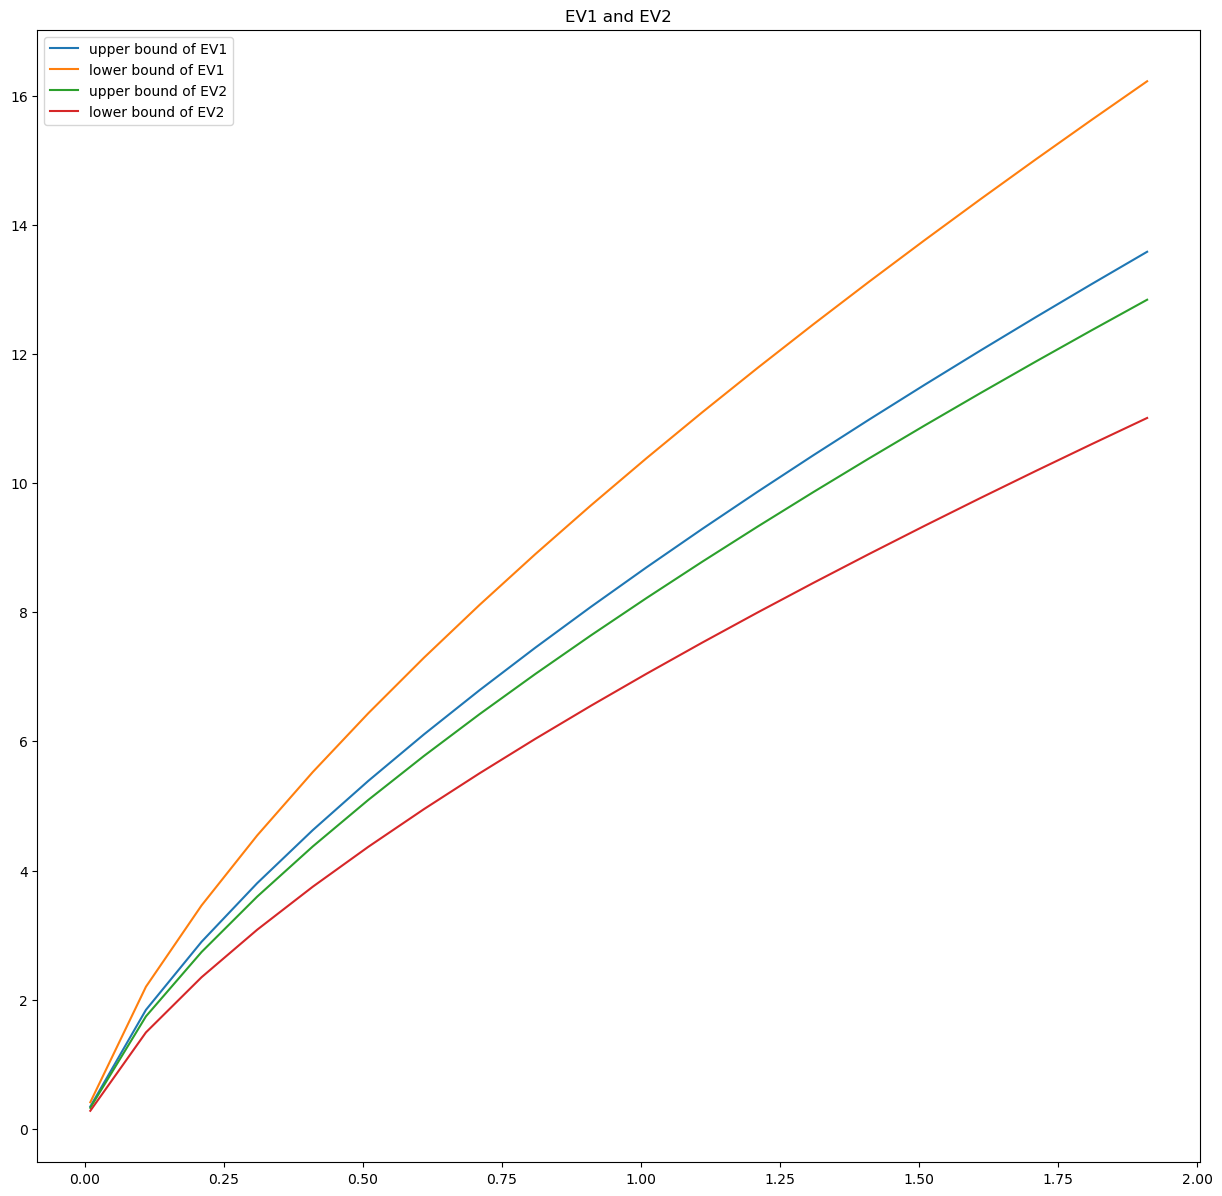

In [7]:
fig = plt.figure(figsize = [15,15], dpi = 100)
ax = plt.subplot(1,1,1)
ax.plot(w1, Ave_V1[:,0], label = 'upper bound of EV1')
ax.plot(w1, Ave_V1[:,1], label = 'lower bound of EV1')
ax.plot(w1, Ave_V2[:,0], label = 'upper bound of EV2')
ax.plot(w1, Ave_V2[:,1], label = 'lower bound of EV2')
plt.legend()
plt.title('EV1 and EV2')
plt.show()

In [33]:
## use Nelder-Mead Algorithm to calculate the equilibrium values of w and lambda
def Obj(w,lambdax, CM, CD):
    
    '''
        Given the value of wage (w) and proportion (lambda), gives out the difference between 
        EV2 and C_D, EV1 and C_M
        
        This objection function is defined as 
            Obj = (EV1 - CM)^2 + (EV2 - CD)^2
    '''
    
    gM, GM = GM_dist(MC.P, h, lambdax ,num_state)
    V1, V2M, V2D, V20 = VF(w, lambdax)
    V2 = Mixed_V2(V2M, V2D, V20, z_grid)
    
    EV1 = np.dot(h, V1)
    EV2 = np.dot(h, np.dot(gM.T, Mixed_V2(V2M, V2D, V20, z_grid).T).T)
    
    Obj1 = (EV1 - CM)**2 + (EV2 - CD)**2
    Obj1 = np.asarray(Obj1)[0][0]
    
    return Obj1

In [34]:
def Nelder_Mead(W, Lambda):
    
    '''
        Use Nelder-Mead Algorithm to update values of w and lambda
    '''
    
    # given the values of w and lambda, calculate the corresponding Obj's values
    diff = np.zeros(3)
    for i in range(3):
        diff[i] = Obj(W[i], Lambda[i], CM, CD)
    
    epsi = 10
    
    while epsi > 1e-6:
        indexmax = np.argmax(diff)
        indexmin = np.argmin(diff)
        indexmid = np.argsort(diff)[-2]
        
        w_1 = W[indexmin] + W[indexmid] - W[indexmax]
        lambda_1 = Lambda[indexmin] + Lambda[indexmid] - Lambda[indexmax]
        
        if w_1 < 0:
            w_2 = 0.01
        if lambda_1 < 0:
            lambda_1 = 0.01
        elif lambda_1 > 0.95:
            lambda_1 = 0.95
        
        diff_1 = Obj(w_1, lambda_1, CM, CD)
        
        if diff_1 < diff[indexmin]:
            w_2 = 1.5*(W[indexmin] + W[indexmid]) - 2*W[indexmax]
            lambda_2 = 1.5*(Lambda[indexmin] + Lambda[indexmid]) - 2*Lambda[indexmax]
            
            if w_2 < 0:
                w_2 = 0.01
            if lambda_2 < 0:
                lambda_2 = 0.01
            elif lambda_2 > 0.95:
                lambda_2 = 0.95
                
            diff_2 = Obj(w_2, lambda_2, CM, CD)
            if diff_1 < diff_2:
                diff[indexmax] = Obj(w_1, lambda_1, CM, CD)
                W[indexmax] = w_1
                Lambda[indexmax] = lambda_1
            else:
                diff[indexmax] = Obj(w_2, lambda_2, CM, CD)
                W[indexmax] = w_2
                Lambda[indexmax] = lambda_2
            
        elif diff_1 > diff[indexmid]:
            w_3 = 0.75*(W[indexmin] + W[indexmid]) - 0.5*W[indexmax]
            lambda_3 = 0.75*(Lambda[indexmin] + Lambda[indexmid]) - 0.5*Lambda[indexmax]
            
            diff_3 = Obj(w_3, lambda_3, CM, CD)
            
            if diff_3 < diff[indexmax]:
                diff[indexmax] = diff_3
                W[indexmax] = w_3
                Lambda[indexmax] = lambda_3
            else:
                w_4 = 0.5*(W[indexmin] + W[indexmid])
                lambda_4 = 0.5*(Lambda[indexmin] + Lambda[indexmid])
                
                w_5 = 0.5*(W[indexmin] + W[indexmax])
                lambda_5 = 0.5*(Lambda[indexmin] + Lambda[indexmax])
                
                diff[indexmid] = Obj(w_4, lambda_4, CM, CD)
                diff[indexmax] = Obj(w_5, lambda_5, CM, CD)
                W[indexmid] = w_4
                W[indexmax] = w_5
                Lambda[indexmid] = lambda_4
                Lambda[indexmax] = lambda_5
        
        else:
            diff[indexmax] = diff_1
            W[indexmax] = w_1
            Lambda[indexmax] = lambda_1
            
        epsi = np.max(diff)
        print(diff, W, Lambda)
        
    return W[indexmin], Lambda[indexmin]
        
        
    
    

In [14]:
V1, V2M, V2D, V20 = VF(w=0.7, lambdax = 0.5)
KK = np.dot(h, V1)
gM, GM = GM_dist(MC.P, h, 0.5 ,num_state)
V2 = Mixed_V2(V2M, V2D, V20, z_grid)
JJ = np.dot(h, np.dot(gM.T, Mixed_V2(V2M, V2D, V20, z_grid).T).T)
KK,JJ

(matrix([[7.7208541]]), matrix([[5.61463883]]))

In [35]:
CM = 7.721
CD = 5.614
W = [0.7,0.73,0.75]
Lambda = [0.45,0.50,0.60]

Nelder_Mead(W, Lambda)

164 9.732483896751722e-07 0.014943122863769531
165 9.045410476282778e-07 0.015025138854980469
165 9.21817952792565e-07 0.01820087432861328
164 9.536989469172215e-07 0.014555692672729492
[0.0027606  0.08113698 0.03348668] [0.7, 0.73, 0.6799999999999999] [0.45, 0.5, 0.35]
164 9.240477506233875e-07 0.03467130661010742
164 9.438596682298593e-07 0.04994535446166992
[0.0027606  0.06824152 0.03348668] [0.7, 0.6699999999999999, 0.6799999999999999] [0.45, 0.3500000000000001, 0.35]
164 9.829601457456235e-07 0.015493154525756836
[0.0027606  0.01613398 0.03348668] [0.7, 0.71, 0.6799999999999999] [0.45, 0.44999999999999996, 0.35]
165 9.045410476282778e-07 0.01975274085998535
164 9.90217046266125e-07 0.008899688720703125
[0.0027606  0.01613398 0.02778975] [0.7, 0.71, 0.7174999999999999] [0.45, 0.44999999999999996, 0.49999999999999994]
164 9.659372405268557e-07 0.015246868133544922
[0.0027606  0.01613398 0.00899098] [0.7, 0.71, 0.6925] [0.45, 0.44999999999999996, 0.39999999999999997]
164 9.5615197009

(0.6999072265624997, 0.4991210937499999)

In [37]:
CM = 7.721
CD = 5.614
W = [0.1,1.0,1.5]
Lambda = [0.1,0.4,0.7]

Nelder_Mead(W, Lambda)

151 9.458915127914046e-07 0.020346641540527344
167 9.183256141920351e-07 0.0176084041595459
169 9.93470554804263e-07 0.018496990203857422
173 9.158573436085682e-07 0.019746065139770508
171 9.282598128113176e-07 0.019823551177978516
168 9.689043770233572e-07 0.04027414321899414
163 9.108812013369836e-07 0.01988959312438965
[ 1.99544643  7.63968316 22.51060031] [0.55, 1.0, 1.25] [0.25, 0.4, 0.55]
158 9.95306133786419e-07 0.010250329971313477
162 9.93174528649565e-07 0.019767045974731445
[1.99544643 7.63968316 2.35315356] [0.55, 1.0, 0.5375000000000001] [0.25, 0.4, 0.21250000000000002]
150 9.545523578980796e-07 0.009606361389160156
159 9.307627390420366e-07 0.02755594253540039
163 9.036231404557856e-07 0.01618671417236328
165 9.4322101446221e-07 0.014945507049560547
[1.99544643 0.63324239 2.17008348] [0.55, 0.775, 0.5437500000000001] [0.25, 0.325, 0.23125]
165 9.48539230507534e-07 0.019745349884033203
[1.99544643 0.63324239 0.71142968] [0.55, 0.775, 0.7812500000000001] [0.25, 0.325, 0.343

(0.6999500899221989, 0.49957559454718725)

In [38]:
V1, V2M, V2D, V20 = VF(w=1.1, lambdax = 0.3)
KK = np.dot(h, V1)
gM, GM = GM_dist(MC.P, h, 0.5 ,num_state)
V2 = Mixed_V2(V2M, V2D, V20, z_grid)
JJ = np.dot(h, np.dot(gM.T, Mixed_V2(V2M, V2D, V20, z_grid).T).T)
KK,JJ

167 9.81683692868893e-07 0.01894974708557129


(matrix([[10.81392302]]), matrix([[7.70420918]]))

In [39]:
CM = 10.814
CD = 7.704
W = [0.1,1.0,1.5]
Lambda = [0.1,0.4,0.7]

Nelder_Mead(W, Lambda)

151 9.458915127914046e-07 0.013963699340820312
167 9.183256141920351e-07 0.041886091232299805
169 9.93470554804263e-07 0.020943164825439453
173 9.158573436085682e-07 0.044878482818603516
171 9.282598128113176e-07 0.014959335327148438
[26.68888396  0.93943469  8.2647606 ] [1.825, 1.0, 1.5] [0.775, 0.4, 0.7]
164 9.487847755185263e-07 0.051859140396118164
166 9.906722601904588e-07 0.02091383934020996
[1.72648039 0.93943469 8.2647606 ] [0.9625, 1.0, 1.5] [0.43750000000000006, 0.4, 0.7]
161 9.90584779212443e-07 0.03922867774963379
164 9.944397328176615e-07 0.024926424026489258
167 9.06238410434142e-07 0.020949363708496094
168 9.689043770233572e-07 0.02096390724182129
[1.30188881 0.93943469 1.07112357] [0.98125, 1.0, 1.25] [0.41875000000000007, 0.4, 0.55]
168 9.790551269661748e-07 0.021935224533081055
168 9.398922440473446e-07 0.02494335174560547
[0.39943269 0.93943469 1.07112357] [1.196875, 1.0, 1.25] [0.503125, 0.4, 0.55]
166 9.79387012671758e-07 0.023934364318847656
167 9.328406641362436e

(1.1142712014241019, 0.3979466636581147)